In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import math
import copy
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [5]:
# Read data
path = '../../../real_monica/data.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(46, 47), dtype=bool)

In [6]:
print(motion.shape)

(5529, 48)


# Dataset Preparation

In [7]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [8]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [9]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [16]:
def get_accelerations_footstep_dataset(dataset, footsteps, debug=False):
    idx = 1
    inputs = []
    labels = []
    
    while idx < len(footsteps):
        if idx > 0:
            # Compute time difference between footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            # Round velocity array
            dataset[footsteps[idx-1], 1:4] = np.round(dataset[footsteps[idx-1], 1:4], 1)
            dataset[footsteps[idx], 1:4] = np.round(dataset[footsteps[idx], 1:4], 1)
            
            if time_difference < 0.4:
                fl_rr_moving = contacts[footsteps[idx], 0]
                fr_rl_moving = contacts[footsteps[idx], 1]
                
                if fl_rr_moving == fr_rl_moving:
                    print("Invalid footstep")
                    idx += 1
                    continue
                    
                # Rotation matrices
                R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 39:43])

                # Retrieve base poses in world frame
                prev_base = dataset[footsteps[idx-1], 16:19]
                curr_base = dataset[footsteps[idx], 16:19]

                # Compute base displacement
                world_displacement = curr_base - prev_base
                base_displacement = np.dot(R_curr.T, world_displacement)
                
                # Compute symmetric feet poses
                symmetryc_feet_poses = copy.deepcopy(dataset[footsteps[idx], 4:16])
                symmetryc_feet_poses[0], symmetryc_feet_poses[3] = symmetryc_feet_poses[3], symmetryc_feet_poses[0]
                symmetryc_feet_poses[6], symmetryc_feet_poses[9] = symmetryc_feet_poses[9], symmetryc_feet_poses[6]
                symmetryc_feet_poses[1], symmetryc_feet_poses[4] = symmetryc_feet_poses[4] * -1, symmetryc_feet_poses[1] * -1
                symmetryc_feet_poses[7], symmetryc_feet_poses[10] = symmetryc_feet_poses[10] * -1, symmetryc_feet_poses[7] * -1
                
                # Add both real and symmetric entries
                inputs.append(dataset[footsteps[idx-2], 1:2].tolist() +
                              dataset[footsteps[idx-1], 1:2].tolist() +
                              dataset[footsteps[idx], 1:2].tolist() +
                              dataset[footsteps[idx-2], 19:20].tolist() +
                              dataset[footsteps[idx-1], 19:20].tolist() +
                              dataset[footsteps[idx], 4:16].tolist() + # feet position w.r.t CoM
                              [fl_rr_moving, fr_rl_moving]) # swiging booleans
                inputs.append(dataset[footsteps[idx-2], 1:2].tolist() +
                              dataset[footsteps[idx-1], 1:2].tolist() +
                              dataset[footsteps[idx], 1:2].tolist() +
                              dataset[footsteps[idx-2], 19:20].tolist() +
                              dataset[footsteps[idx-1], 19:20].tolist() +
                              symmetryc_feet_poses.tolist() + # feet position w.r.t CoM
                              [not fl_rr_moving, not fr_rl_moving]) # swiging booleans
                
                if fl_rr_moving:
                    fl_displacement = (dataset[footsteps[idx], 4:7] - dataset[footsteps[idx-1], 4:7]) + base_displacement
                    rr_displacement = (dataset[footsteps[idx], 13:16] - dataset[footsteps[idx-1], 13:16]) + base_displacement
                    labels.append([fl_displacement[0], fl_displacement[1], rr_displacement[0], rr_displacement[1]])
                    labels.append([fl_displacement[0], fl_displacement[1], rr_displacement[0], rr_displacement[1]])
                    print(f"{dataset[footsteps[idx-1], 1]} -> {dataset[footsteps[idx], 1]}. {dataset[footsteps[idx-1], 19]} -> {dataset[footsteps[idx], 19]}. {fl_displacement[0]}")
                else:
                    fr_displacement = (dataset[footsteps[idx], 7:10] - dataset[footsteps[idx-1], 7:10]) + base_displacement
                    rl_displacement = (dataset[footsteps[idx], 10:13] - dataset[footsteps[idx-1], 10:13]) + base_displacement
                    labels.append([fr_displacement[0], fr_displacement[1], rl_displacement[0], rl_displacement[1]])
                    labels.append([fr_displacement[0], fr_displacement[1], rl_displacement[0], rl_displacement[1]])
                    print(f"{dataset[footsteps[idx-1], 1]} -> {dataset[footsteps[idx], 1]}. {dataset[footsteps[idx-1], 19]} -> {dataset[footsteps[idx], 19]}. {fl_displacement[0]}")
            
        idx += 1
        
    # Convert to numpy array
    inputs_numpy = np.array(inputs)
    labels_numpy = np.array(labels)
    
    return inputs_numpy, labels_numpy

# Stack datasets
X_feet, Y_feet = get_accelerations_footstep_dataset(motion, np.array([x for x in range(len(motion))]))

# Log
print(X_feet.shape)
print(Y_feet.shape)

0.1 -> 0.1. 0.0841218605638 -> 0.115657001734. 0.06514135077092176
0.1 -> 0.1. 0.115657001734 -> 0.106389574707. 0.06514135077092176
0.1 -> 0.1. 0.106389574707 -> 0.103669390082. 0.05683650909804322
0.1 -> 0.1. 0.103669390082 -> 0.0915225818753. 0.05683650909804322
0.1 -> 0.1. 0.0915225818753 -> 0.094503454864. 0.06180666254871135
0.1 -> 0.1. 0.094503454864 -> 0.0767145976424. 0.06180666254871135
0.1 -> 0.1. 0.0767145976424 -> 0.11576128751. 0.057806876583970476
0.1 -> 0.1. 0.11576128751 -> 0.0981658995152. 0.057806876583970476
0.1 -> 0.1. 0.0981658995152 -> 0.109702885151. 0.06196469246303961
0.1 -> 0.1. 0.109702885151 -> 0.0923088043928. 0.06196469246303961
0.1 -> 0.1. 0.0923088043928 -> 0.107880532742. 0.05742600857740143
0.1 -> 0.1. 0.107880532742 -> 0.114608556032. 0.05742600857740143
0.1 -> 0.1. 0.114608556032 -> 0.0970489904284. 0.06370111263677758
0.1 -> 0.1. 0.0970489904284 -> 0.0992748364806. 0.06370111263677758
0.1 -> 0.1. 0.0992748364806 -> 0.105194784701. 0.059051156109923

In [17]:
%store X_feet
%store Y_feet

Stored 'X_feet' (ndarray)
Stored 'Y_feet' (ndarray)


In [18]:
X_feet[0]

array([ 0.        ,  0.1       ,  0.1       , -0.00213642,  0.08412186,
        0.25670975,  0.12952206, -0.37686843,  0.21840721, -0.1272198 ,
       -0.37820482, -0.28012648,  0.12935087, -0.384195  , -0.24282894,
       -0.13128586, -0.3797746 ,  1.        ,  0.        ])

In [26]:
dic = dict()
for x in range(len(X_feet)):
    key = str(round(X_feet[x, 2], 1)) + str(round(X_feet[x, 0], 1))
    if key in dic:
        dic[key][0].append(Y_feet[x, 0])
        dic[key][1].append(X_feet[x, 3])
        dic[key][2].append(X_feet[x, 7:13])
    else:
        dic[key] = [[Y_feet[x, 0]], 
                    [X_feet[x, 3]],
                    [X_feet[x, 7:13]]]

In [27]:
dic.keys()

dict_keys(['0.10.1', '0.10.2', '0.20.2', '0.20.3', '0.30.3', '0.30.0', '0.00.0', '0.00.3', '0.30.4', '0.40.4', '0.40.0', '0.00.4', '0.40.5', '0.50.5', '0.50.0', '0.00.5', '0.50.6', '0.60.6', '0.60.0', '0.00.6', '0.60.7', '0.70.7', '0.70.0', '0.00.7', '0.70.8', '0.80.8', '0.80.0', '0.00.8', '0.80.9', '0.90.9', '0.90.0', '0.00.9', '0.91.0', '1.01.0', '1.00.0', '0.01.0', '0.10.0', '0.00.1', '0.20.1', '0.00.2', '0.10.3', '0.30.1', '0.10.4', '0.40.1', '0.10.5', '0.50.1', '0.10.6', '0.60.1', '0.10.7', '0.70.1', '0.10.8', '0.80.1', '0.10.9', '0.90.1', '0.11.0', '1.00.1', '1.00.2', '0.20.0', '0.30.2', '0.20.4', '0.40.2', '0.50.2', '0.20.5', '0.20.6', '0.60.2', '0.20.7', '0.70.2', '0.20.8', '0.80.2', '0.20.9', '0.90.2', '0.21.0', '1.00.3', '0.40.3', '0.30.5', '0.50.3', '0.30.6', '0.60.3', '0.30.7', '0.70.3', '0.30.8', '0.80.3', '0.90.3', '0.30.9', '0.31.0', '1.00.4', '0.50.4', '0.40.6', '0.60.4', '0.40.7', '0.70.4', '0.40.8', '0.80.4', '0.40.9', '0.90.4', '0.41.0', '1.00.5', '0.60.5', '0.70.5',

In [28]:
for key in dic.keys():
    #print(f"{key[:3]} -> {key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 4)}. Std: {np.round(np.std(dic[key][0]), 3)}.")
    if float(key[:3]) == 0.9 and float(key[3:]) == 0.0:
        for x in range(len(dic[key][0])):
            print(f"Actual velocity: {dic[key][1][x]}. Displacement: {dic[key][0][x]}. Feet {dic[key][2][x]}")

Actual velocity: 0.951879024506. Displacement: 0.4824251605593202. Feet [ 0.38131219  0.1360493  -0.36459389  0.16237    -0.13785326 -0.37826481]
Actual velocity: 0.951879024506. Displacement: 0.4824251605593202. Feet [ 0.16237     0.13785326 -0.36459389  0.38131219 -0.1360493  -0.37826481]
Actual velocity: 0.894225358963. Displacement: 0.4477554411398488. Feet [ 0.16388114  0.14124086 -0.3839547   0.37032759 -0.13881585 -0.36991748]
Actual velocity: 0.894225358963. Displacement: 0.4477554411398488. Feet [ 0.37032759  0.13881585 -0.3839547   0.16388114 -0.14124086 -0.36991748]
Actual velocity: 0.84120374918. Displacement: 0.43065110888390146. Feet [ 0.36418983  0.14373881 -0.36047029  0.17160715 -0.13051566 -0.37622926]
Actual velocity: 0.84120374918. Displacement: 0.43065110888390146. Feet [ 0.17160715  0.13051566 -0.36047029  0.36418983 -0.14373881 -0.37622926]
Actual velocity: 0.877080857754. Displacement: 0.5596627631583635. Feet [ 0.39130014  0.13781588 -0.34410799  0.07148866 -0.

In [29]:
for key in dic.keys():
    #print(f"{key[:3]} -> {key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 4)}. Std: {np.round(np.std(dic[key][0]), 3)}.")
    if float(key[:3]) == 0.0 and float(key[3:]) == 0.1:
        for x in range(len(dic[key][0])):
            print(f"Actual velocity: {dic[key][1][x]}. Displacement: {dic[key][0][x]}. Feet {dic[key][2][x]}")

Actual velocity: -0.0202719047666. Displacement: -0.0032366478754149754. Feet [ 0.23989712  0.13008891 -0.36954898  0.23820239 -0.13036484 -0.37337548]
Actual velocity: -0.0202719047666. Displacement: -0.0032366478754149754. Feet [ 0.23820239  0.13036484 -0.36954898  0.23989712 -0.13008891 -0.37337548]
Actual velocity: -0.0216233208776. Displacement: -0.0021026188684833465. Feet [ 0.23920093  0.13048717 -0.37466696  0.23612125 -0.12805313 -0.37770998]
Actual velocity: -0.0216233208776. Displacement: -0.0021026188684833465. Feet [ 0.23612125  0.12805313 -0.37466696  0.23920093 -0.13048717 -0.37770998]
Actual velocity: -0.038851801306. Displacement: -0.004238215518048597. Feet [ 0.23855385  0.1286165  -0.380173    0.23421311 -0.1291576  -0.38022503]
Actual velocity: -0.038851801306. Displacement: -0.004238215518048597. Feet [ 0.23421311  0.1291576  -0.380173    0.23855385 -0.1286165  -0.38022503]
Actual velocity: -0.0510587990284. Displacement: -0.011126859731901714. Feet [ 0.23707493  0

In [30]:
#for key in dic.keys():
#    print(f"Prev: {key[:3]}. Actual: {key[3:]}. \n\nDisp: {dic[key]}\n\n.")

In [31]:
#for x in range(len(X_feet)):
#    print(f"{X_feet[x, 0]} -> {X_feet[x, 3]}. Step: {np.round(Y_feet[x, 0], 2)}. CoM: {np.round(X_feet[x, -5:-4], 2)}. FL: {np.round(X_feet[x, 10], 3)}. FR: {np.round(X_feet[x, 13], 3)}. RL: {np.round(X_feet[x, 16], 3)}. RR: {np.round(X_feet[x, 19], 3)}")

0.0 -> 0.0. Mean: -0.002. Std: 0.045
0.1 -> 0.1. Mean: 0.105. Std: 0.104
0.2 -> 0.2. Mean: 0.155. Std: 0.088
0.3 -> 0.3. Mean: 0.204. Std: 0.092
0.4 -> 0.4. Mean: 0.245. Std: 0.066
0.5 -> 0.5. Mean: 0.292. Std: 0.066
0.6 -> 0.6. Mean: 0.342. Std: 0.071
0.7 -> 0.7. Mean: 0.39. Std: 0.082
0.8 -> 0.8. Mean: 0.441. Std: 0.095
0.9 -> 0.9. Mean: 0.481. Std: 0.119
1.0 -> 1.0. Mean: 0.539. Std: 0.124


<ErrorbarContainer object of 3 artists>

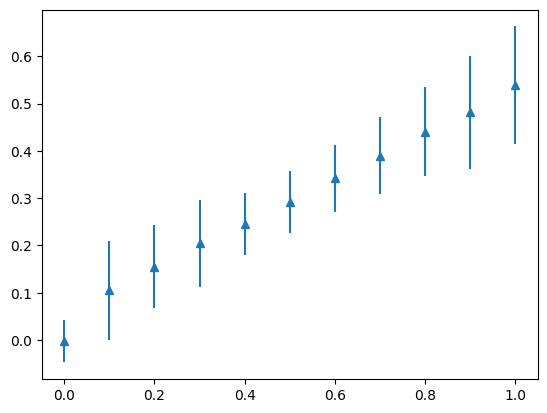

In [32]:
x, y, e = [], [], []

for vel in np.round(np.arange(0.0, 1.1, 0.1), 2):
    start = vel
    key = str(start)+str(vel)
    print(f"{start} -> {vel}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}")
    x.append(vel)
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')

0.0 -> 0.0. Mean: -0.002. Std: 0.045
0.1 -> 0.1. Mean: 0.105. Std: 0.104
0.2 -> 0.2. Mean: 0.155. Std: 0.088
0.3 -> 0.3. Mean: 0.204. Std: 0.092
0.4 -> 0.4. Mean: 0.245. Std: 0.066
0.5 -> 0.5. Mean: 0.292. Std: 0.066
0.6 -> 0.6. Mean: 0.342. Std: 0.071
0.7 -> 0.7. Mean: 0.39. Std: 0.082
0.8 -> 0.8. Mean: 0.441. Std: 0.095
0.9 -> 0.9. Mean: 0.481. Std: 0.119
1.0 -> 1.0. Mean: 0.539. Std: 0.124


<ErrorbarContainer object of 3 artists>

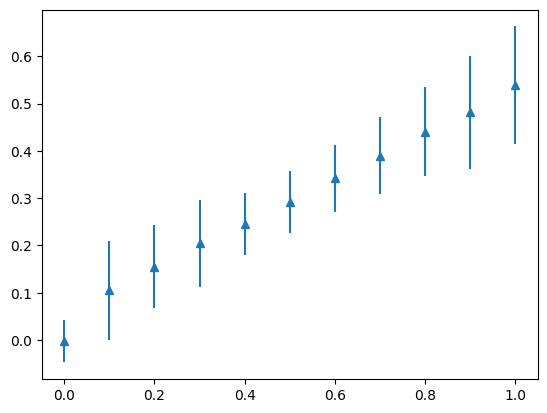

In [33]:
x, y, e = [], [], []

for vel in np.round(np.arange(0.0, 1.1, 0.1), 2):
    start = vel
    key = str(start)+str(vel)
    print(f"{start} -> {vel}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}")
    x.append(vel)
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')